In [17]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zver\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zver\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Zver\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Zver\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Загрузка данных

In [32]:
df_train = pd.read_csv('vacancies_train.csv')
df_train

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0
...,...,...,...,...,...,...,...
16624,Полицейский специального полка полиции,Нет опыта,Полный день,Полная занятость,Обязанности: обеспечение общественного поряд...,"['Грамотная речь', 'Обучение и развитие', 'Упр...",67500.0
16625,Врач стоматолог-ортопед (г. Новосибирск),Нет опыта,Полный день,Полная занятость,Обязанности: Оказывает квалифицированную меди...,['Медицинская документация'],50000.0
16626,Фармацевт,От 1 года до 3 лет,Полный день,Полная занятость,Условия: официальное оформление по ТК РФ; гра...,"['Пользователь ПК', 'Работа в команде', 'Грамо...",50000.0
16627,Геодезист (автодороги),От 1 года до 3 лет,Вахтовый метод,Полная занятость,Обязанности: своевременное и качественное вып...,[],75000.0


In [33]:
df_test = pd.read_csv('vacancies_test.csv', index_col=0)
df_test

,name,experience,schedule,employment,description,key_skills
id,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо..."
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени..."
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[]
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д..."
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[]
...,...,...,...,...,...,...
5538,Специалист по дистанционному контролю качества...,От 1 года до 3 лет,Удаленная работа,Полная занятость,Обязанности: проводить визуальный контроль а...,"['Удаленная работа', 'Грамотная речь', 'Пользо..."
5539,Продавец-консультант,Нет опыта,Полный день,Полная занятость,Компания ONE SMOKE приглашает к сотрудничеству...,"['Пользователь ПК', 'Розничная торговля', 'Раб..."
5540,Фельдшер скорой медицинской помощи,От 3 до 6 лет,Сменный график,Полная занятость,Обязанности: Осуществляет оказание скорой мед...,[]


## Простейший EDA

Для начала посмотрим на распределение таргета в трейне

In [34]:
sns.set(rc={'figure.figsize':(9, 6)})

<AxesSubplot:xlabel='salary', ylabel='Count'>

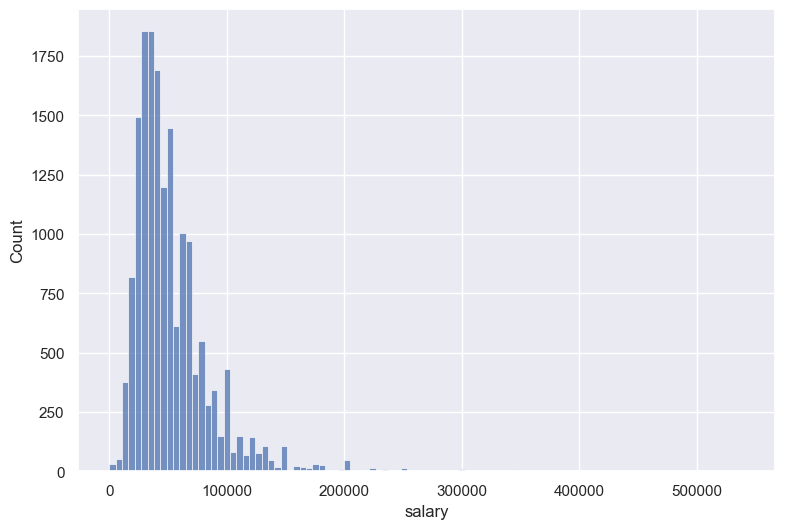

In [35]:
sns.histplot(df_train.salary, bins=100)

В логарифмированной шкале распределение больше похоже на нормальное

<AxesSubplot:xlabel='salary', ylabel='Count'>

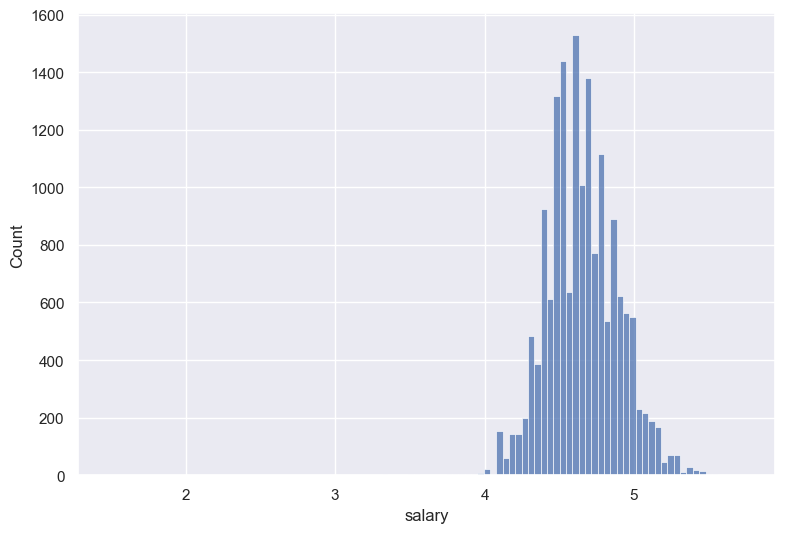

In [36]:
sns.histplot(np.log10(df_train.salary + 1), bins=100)

Видим выбросы слишком высокой и слишком низкой зарплаты. Посмотрим на эти вакансии

In [37]:
df_train[df_train.salary > 200000].sample(5)

,name,experience,schedule,employment,description,key_skills,salary
5483,Lead frontend разработчик,От 3 до 6 лет,Удаленная работа,Полная занятость,Ищем опытного фронтед разработчика к нам в ком...,"['JavaScript', 'ООП', 'Работа в команде', 'Rea...",225000.0
10148,Главный геолог,От 3 до 6 лет,Полный день,Полная занятость,Обязанности: Руководство геологической служб...,[],250000.0
9968,Водитель со своим грузовым автомобилем,От 1 года до 3 лет,Полный день,Полная занятость,"Обязанности: Доставка, Перевозка,Экспедирова...",[],215000.0
9634,Сварщик технологических трубопроводов,От 3 до 6 лет,Вахтовый метод,Полная занятость,Коллектив крупной строительной компании пригла...,"['Сварочные работы', 'Монтаж металлоконструкци...",310000.0
14330,Java-программист,Более 6 лет,Удаленная работа,Полная занятость,Обязанности: Развитие и оптимизация программно...,"['Java', 'PostgreSQL', 'SQL', 'Gitlab', 'HTML'...",300000.0


In [41]:
df_train[df_train.salary < 10000].sample(5)

,name,experience,schedule,employment,description,key_skills,salary
5245,"Мерчендайзер (напитки), Лебяжье",От 1 года до 3 лет,Гибкий график,Частичная занятость,"Международная компания «АНКОР», лидер кадровог...","['Пополнение товарных запасов', 'Выкладка това...",3354.0
2641,Продавец консультант/старший(ТЦ Эльгрин),От 1 года до 3 лет,Полный день,Полная занятость,Должностные обязанности: - консультирование кл...,"['Клиентоориентированность', 'Мерчандайзинг', ...",30.0
6453,Интервьюер,Нет опыта,Полный день,Проектная работа,Обязанности: Проведение опроса сотрудников на ...,"['Пользователь ПК', 'Работа в команде', 'Прове...",1000.0
621,Повар-универсал,Нет опыта,Полный день,Полная занятость,Обязанности Повар универсал. Заготовка полуфа...,"['Общественное питание', 'Проведение инвентари...",1800.0
6147,Домработница/Домработник,От 1 года до 3 лет,Гибкий график,Частичная занятость,Требуется домработница 3 раза в 2 недели Обяза...,['Умение расставлять приоритеты'],3500.0


Судя по всему на подобных вакансиях заплата приведена за смену или вовсе некорректна, поэтому удалим все вакансии с зарплатой менее 10000

In [42]:
df_train = df_train[df_train.salary > 10000]

Посмотрим на наиболее популярные должности

In [43]:
df_train.name.value_counts()

Менеджер по продажам                               208
Продавец-консультант                               180
Кладовщик                                          111
Менеджер по работе с клиентами                     111
Бухгалтер                                          108
                                                  ... 
Менеджер по тендерам                                 1
Менеджер по персоналу (Интернет-магазин)             1
Специалист по недвижимости ( без поиска )            1
Администратор магазина (Чусовой, Ленина, 50)         1
Специалист-эксперт отдела правового обеспечения      1
Name: name, Length: 9869, dtype: int64

По графику ниже, видим, что вакансий для опытных соискателей сравнительно немного

<AxesSubplot:xlabel='experience', ylabel='Count'>

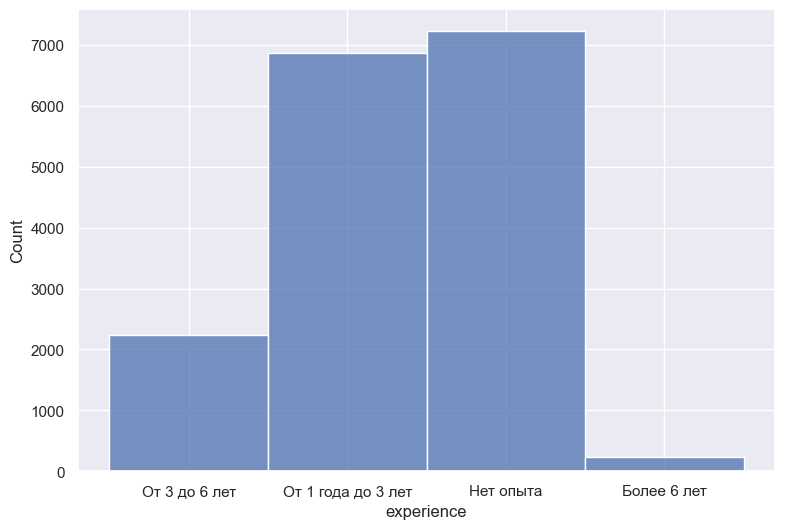

In [18]:
sns.histplot(df_train.experience)

Попробуем визуализировать совместное распределение опыта работы и предлагаемой зп

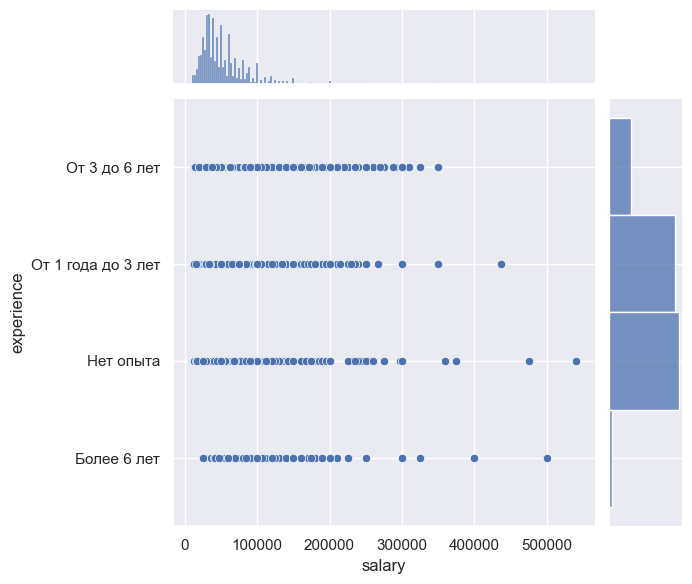

In [44]:
sns.jointplot(x='salary', y='experience', data=df_train)

Вакансий с графиком занятостью, отличной от полной так же немного

<AxesSubplot:xlabel='schedule', ylabel='Count'>

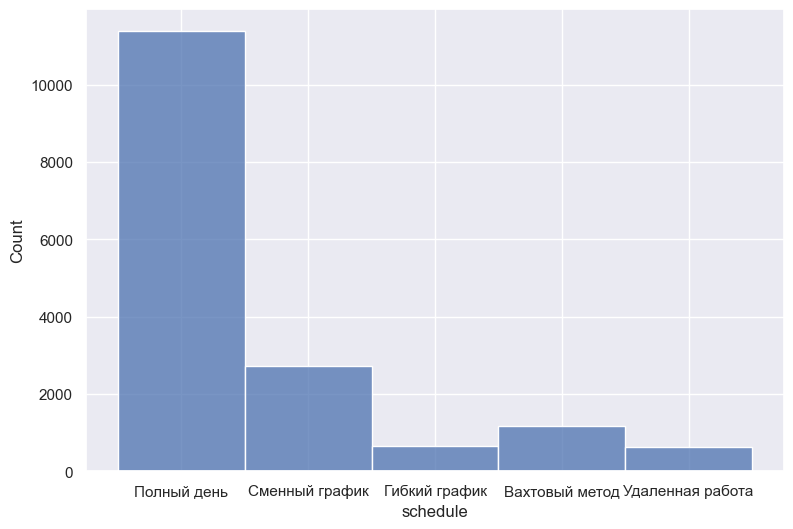

In [45]:
sns.histplot(df_train.schedule)

<AxesSubplot:xlabel='employment', ylabel='Count'>

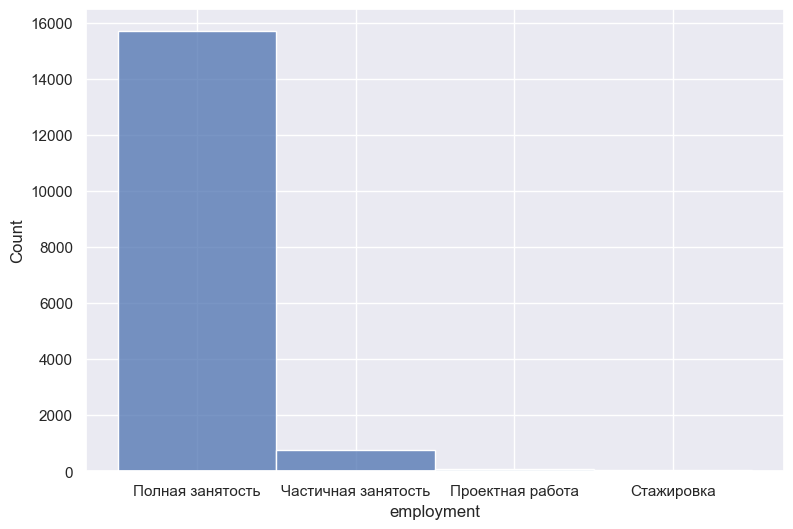

In [46]:
sns.histplot(df_train.employment)

Посмотрим, как часто различные требуемые навыки встречаются в поле `key_skills` в зависимости от размера зарплаты

In [47]:
from ast import literal_eval
from collections import OrderedDict

In [48]:
for i in range(10000, 180000, 20000):
    skills_count = dict()
    df_train_salary = df_train[(df_train.salary < 20000 + i) & (df_train.salary >= i)]
    for skill_list in df_train_salary.key_skills:
        list_of_skills = literal_eval(skill_list)
        for skill in list_of_skills:
            if skill not in skills_count:
                skills_count[skill] = 1
            else:
                skills_count[skill] += 1

    skills_count = [[k, v] for k, v in sorted(skills_count.items(), key=lambda item: item[1], reverse=True)]
    print(f'От {i} до {20000 + i}:\n {skills_count[:5]}\n')


От 10000 до 30000:
 [['Пользователь ПК', 624], ['Работа в команде', 537], ['Грамотная речь', 482], ['Умение работать в команде', 247], ['Деловое общение', 151]]

От 30000 до 50000:
 [['Пользователь ПК', 1136], ['Работа в команде', 1125], ['Грамотная речь', 939], ['Умение работать в команде', 472], ['Активные продажи', 373]]

От 50000 до 70000:
 [['Работа в команде', 573], ['Пользователь ПК', 501], ['Грамотная речь', 458], ['Активные продажи', 293], ['Умение работать в команде', 214]]

От 70000 до 90000:
 [['Работа в команде', 254], ['Пользователь ПК', 193], ['Грамотная речь', 154], ['Активные продажи', 131], ['Умение работать в команде', 103]]

От 90000 до 110000:
 [['Работа в команде', 144], ['Грамотная речь', 89], ['Пользователь ПК', 88], ['Активные продажи', 66], ['AutoCAD', 59]]

От 110000 до 130000:
 [['Работа в команде', 47], ['Пользователь ПК', 37], ['Ведение переговоров', 35], ['Грамотная речь', 35], ['AutoCAD', 29]]

От 130000 до 150000:
 [['Пользователь ПК', 21], ['Работа в к

В вакансиях с зарплатой до 50000 рублей самый популярный навык - это 'пользователь пк', после 50000 - 'работа в команде', после 170000 - 'ведение переговоров'. В целом, большинство самых популярных навыков встречаются при любых зарплатах

Визуализируем распределения тестовых данных

<AxesSubplot:xlabel='employment', ylabel='Count'>

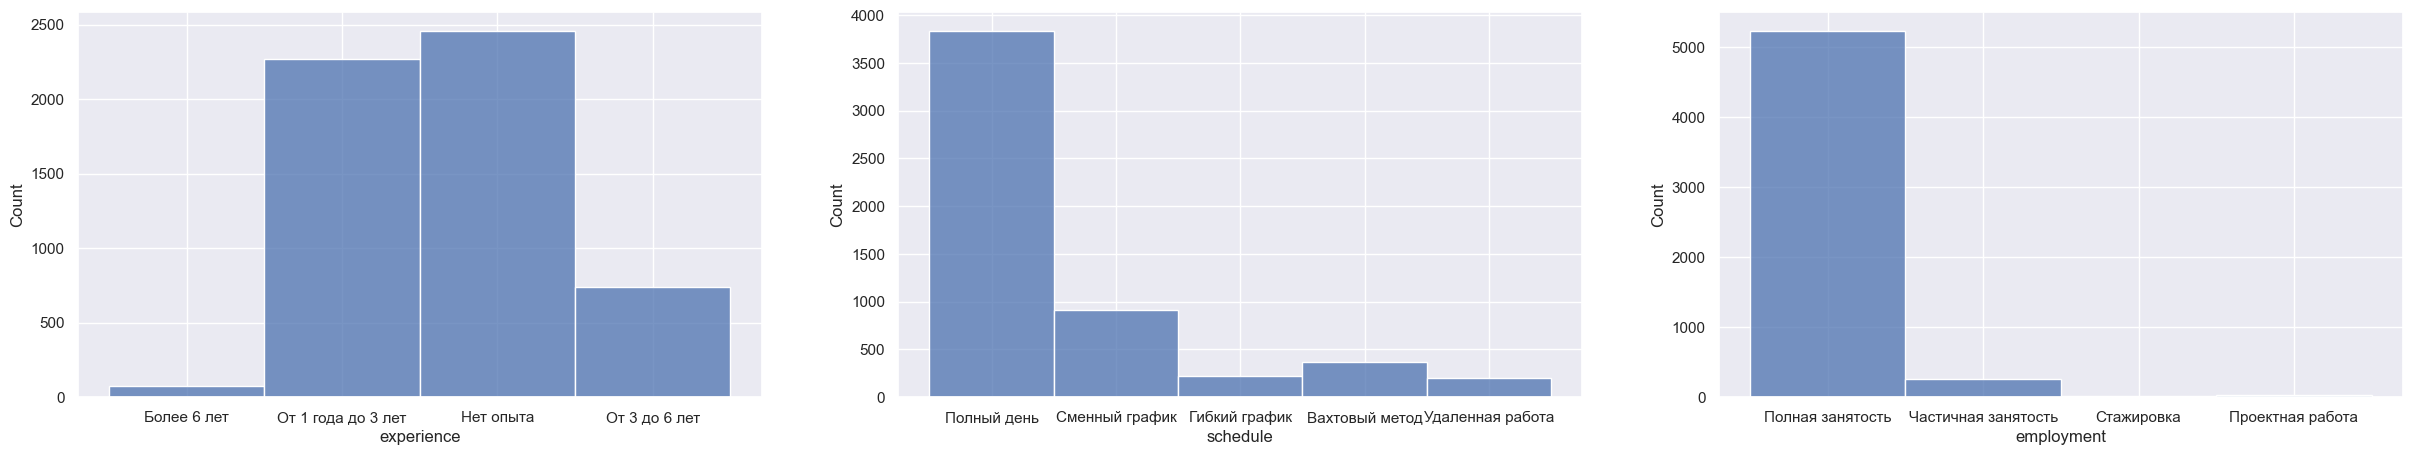

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
sns.histplot(ax=axes[0], data=df_test.experience)
sns.histplot(ax=axes[1], data=df_test.schedule)
sns.histplot(ax=axes[2], data=df_test.employment)

Для тестовой выборки распределения аналогичные

## Preprocessing

Используем только описание вакансии, ее название и требуемые навыки

In [50]:
df_train_new = pd.DataFrame()
df_train_new['text'] = df_train.name + ' ' + df_train.description + ' ' + df_train.key_skills
df_train_new

,text
0,Водитель-экспедитор Водитель-экспедитор катего...
1,Кладовщик-комплектовщик/оператор 1С Обязанност...
2,"Продавец магазина ""Магнит"" (Кировский р-он, В...."
3,Администратор магазина (ТЦ Spar) Крупная федер...
4,Мойщик посуды (кулинария) Обязанности: Уборка...
...,...
16624,Полицейский специального полка полиции Обязанн...
16625,Врач стоматолог-ортопед (г. Новосибирск) Обяза...
16626,Фармацевт Условия: официальное оформление по ...
16627,Геодезист (автодороги) Обязанности: своевреме...


In [53]:
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

# функция для очистки описаний
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
    text = re.sub('[^а-яА-ЯёЁa-zA-Z0-9$-_@.&+]', ' ', text) # оставляем только буквенные символы и цифры
    text = word_tokenize(text.lower()) # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова
    text = [morph.normal_forms(token)[0] for token in text 
            if token not in stop_words]
    text = " ".join(text) # возвращаем строку
    return text

In [54]:
from tqdm import tqdm

cleaned = list(tqdm(map(clean_text, df_train_new.text), total=len(df_train_new)))
df_train_new['cleaned'] = cleaned

100%|██████████| 16552/16552 [06:07<00:00, 45.06it/s]


In [55]:
df_train_new.sample(5)

,text,cleaned
5030,Водитель – экспедитор на личном грузовом автом...,водитель экспедитор личный грузовой автомобиль...
16483,Инженер строительного контроля (г.Братск) Дл...,инженер строительный контроль ( г.братск ) раб...
15530,Специалист по недвижимости Специалист по недви...,специалист недвижимость специалист недвижимост...
6559,Комплектовщик заказов Мы предлагаем: • Место р...,комплектовщик заказ предлагать : место работа ...
13055,Грузчик Обязанности: Работа на металлобазе Осн...,грузчик обязанность : работа металлобаза основ...


In [56]:
df_test_new = pd.DataFrame()
df_test_new['text'] = df_test.name + ' ' + df_test.description + ' ' + df_test.key_skills
df_test_new['cleaned'] = list(tqdm(map(clean_text, df_test_new.text), total=len(df_test_new)))

100%|██████████| 5543/5543 [02:03<00:00, 44.97it/s]


In [57]:
df_test_new.sample(5)

,text,cleaned
id,,
5368,Врач-фтизиатр Работа на территории работодател...,врач-фтизиатр работа территория работодатель :...
1774,Медицинская сестра Работа на территории работо...,медицинский сестра работа территория работодат...
1159,Администратор мини-отеля Чем предстоит занимат...,администратор мини-отель предстоять заниматься...
1048,Инженер ПТО Обязанности: Ведение исполнительн...,инженер пто обязанность : ведение исполнительн...
2888,Диспетчер-логист Обязанности: Осуществляет опе...,диспетчер-логист обязанность : осуществлять оп...


## Word2Vec

Обучаемся на словах только из трейна

In [204]:
%%time
w2v_model = Word2Vec(sentences=list(df_train_new.cleaned.str.split()),
                     vector_size=300, window=10, workers=4, min_count=10, sg=1)

Wall time: 39.7 s


Проверяем, успешно ли обучился w2v на наших данных

In [205]:
w2v_vectors = w2v_model.wv
w2v_vectors['водитель'] # проверяем, что чему-то научились

array([ 0.0944379 ,  0.21418926, -0.22632654, -0.11888686,  0.70886344,
       -0.79718745,  0.02702344,  0.49332872, -0.18775219, -0.29998836,
        0.05484166, -0.23368031,  0.153954  , -0.05939825, -0.40517932,
       -0.41956908,  0.15932778,  0.00210418, -0.05779652, -0.19261111,
       -0.195494  ,  0.13914497,  0.39767495, -0.3298248 ,  0.11899439,
        0.18110089, -0.25358248, -0.06357757,  0.03251795,  0.19993365,
       -0.02630862, -0.1340417 , -0.26586446,  0.08214465, -0.12296896,
        0.01383606, -0.15036568, -0.24760802,  0.09263512, -0.10299931,
        0.04741222,  0.04431294, -0.04804245, -0.40877634, -0.39630526,
        0.07110142, -0.0837408 , -0.39822957,  0.35571504,  0.14111176,
        0.20579208,  0.23380537, -0.11932699,  0.560521  ,  0.21684437,
        0.08878993,  0.39869508,  0.08894476, -0.17851642,  0.38523376,
        0.1836656 ,  0.13597474,  0.04341172, -0.44294223, -0.36665654,
       -0.09873839, -0.26974264,  0.18595152,  0.12865569,  0.11

In [206]:
len(w2v_vectors)

9227

In [207]:
w2v_vectors.most_similar('smm')

[('pr', 0.7951592206954956),
 ('seo', 0.76413893699646),
 ('таргетировать', 0.7546537518501282),
 ('контекст', 0.7425912022590637),
 ('tiktok', 0.7252269983291626),
 ('facebook', 0.7190153002738953),
 ('медийный', 0.7116972208023071),
 ('таргет', 0.7091341614723206),
 ('копирайтер', 0.6984425187110901),
 ('fb', 0.6980567574501038)]

Усредняем эмбеддинги слов каждой отдельной вакансии, чтобы получить эмбеддинг, характеризующий, собственно, все текстовое описание вакансии

In [208]:
def get_tweet_embedding(df, model=w2v_model.wv, embedding_size=200):

    doc_vectors = []
    for doc in tqdm(df.cleaned.str.split()):
        res = np.zeros(embedding_size)
        cnt = 0
        for word in doc:
            if model.__contains__(word):
                res +=  model[word]
                cnt += 1
        if cnt != 0:
            res /= cnt
        doc_vectors.append(res)
    return doc_vectors

doc_vectors_train = np.array(get_tweet_embedding(df_train_new, model=w2v_model.wv, embedding_size=300))
doc_vectors_test = np.array(get_tweet_embedding(df_test_new, model=w2v_model.wv, embedding_size=300))

100%|██████████| 5543/5543 [00:02<00:00, 1875.90it/s]


Закодируем категориальные признаки

In [209]:
ohe = OneHotEncoder()

cat_train = ohe.fit_transform(df_train[['experience', 'schedule', 'employment']])
# doc_vectors_train = np.concatenate((doc_vectors_train, cat_train.toarray()), axis=1)

cat_test = ohe.fit_transform(df_test[['experience', 'schedule', 'employment']])
# doc_vectors_test = np.concatenate((doc_vectors_test, cat_test.toarray()), axis=1)


## fastText

In [316]:
import fasttext
import fasttext.util

In [ ]:
ft = fasttext.load_model('D:\\Kitaysky\\Step_in_NLP\\8. Other embedding\\cc.ru.300.bin')

In [355]:
def get_tweet_embedding(df, model=w2v_model.wv, embedding_size=200):
    doc_vectors = []
    for doc in tqdm(df.cleaned.str.split()):
        res = np.zeros(embedding_size)
        cnt = 0
        for word in doc:
            res += model[word]
            cnt += 1
        if cnt != 0:
            res /= cnt
        doc_vectors.append(res)
    return doc_vectors

doc_vectors_train_ft = np.array(get_tweet_embedding(df_train_new, model=ft, embedding_size=300))
doc_vectors_test_ft = np.array(get_tweet_embedding(df_test_new, model=ft, embedding_size=300))

100%|██████████| 5543/5543 [00:07<00:00, 750.80it/s]


In [ ]:
ft.get_nearest_neighbors('sql')

## Fit & Predict

- Lasso-регрессия

In [68]:
lasso = Lasso(alpha=1, max_iter=1000)
%time lasso.fit(doc_vectors_train, df_train.salary)
y_pred = lasso.predict(doc_vectors_test)

Wall time: 3.35 s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+12, tolerance: 1.938e+09
  model = cd_fast.enet_coordinate_descent(


- GridSearchCV

In [66]:
param = {
    'alpha': [1, 1.2, 1.5, 1.7, 2], 
    'max_iter': [1000, 2000, 5000, 10000]
}
cv_model = GridSearchCV(Lasso(), param, cv=5, verbose=2)
cv_model.fit(doc_vectors_train, df_train.salary)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.388e+12, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=1000; total time=   3.1s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.523e+11, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=1000; total time=   2.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.386e+12, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=1000; total time=   2.7s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.881e+11, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=1000; total time=   2.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.889e+11, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=1000; total time=   4.1s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e+11, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=2000; total time=   7.3s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e+11, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=2000; total time=   6.2s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e+11, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=2000; total time=   5.7s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.494e+10, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=2000; total time=   5.4s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.060e+10, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=1, max_iter=2000; total time=   6.2s
[CV] END .............................alpha=1, max_iter=5000; total time=  11.8s
[CV] END .............................alpha=1, max_iter=5000; total time=  13.0s
[CV] END .............................alpha=1, max_iter=5000; total time=  11.3s
[CV] END .............................alpha=1, max_iter=5000; total time=  13.5s
[CV] END .............................alpha=1, max_iter=5000; total time=  12.5s
[CV] END ............................alpha=1, max_iter=10000; total time=  12.4s
[CV] END ............................alpha=1, max_iter=10000; total time=  12.9s
[CV] END ............................alpha=1, max_iter=10000; total time=  13.8s
[CV] END ............................alpha=1, max_iter=10000; total time=  13.6s
[CV] END ............................alpha=1, max_iter=10000; total time=  13.3s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.575e+11, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=1000; total time=   3.3s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.947e+11, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=1000; total time=   2.9s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.620e+11, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=1000; total time=   3.1s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.599e+11, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=1000; total time=   4.2s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.441e+11, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=1000; total time=   6.1s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.544e+10, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=2000; total time=   7.6s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.250e+10, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=2000; total time=   7.1s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.729e+10, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=2000; total time=   9.3s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.548e+10, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=2000; total time=   9.8s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.664e+10, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.2, max_iter=2000; total time=   6.4s
[CV] END ...........................alpha=1.2, max_iter=5000; total time=  10.3s
[CV] END ...........................alpha=1.2, max_iter=5000; total time=  11.7s
[CV] END ...........................alpha=1.2, max_iter=5000; total time=  10.8s
[CV] END ...........................alpha=1.2, max_iter=5000; total time=   9.6s
[CV] END ...........................alpha=1.2, max_iter=5000; total time=   9.7s
[CV] END ..........................alpha=1.2, max_iter=10000; total time=  10.6s
[CV] END ..........................alpha=1.2, max_iter=10000; total time=  11.7s
[CV] END ..........................alpha=1.2, max_iter=10000; total time=  10.3s
[CV] END ..........................alpha=1.2, max_iter=10000; total time=   9.7s
[CV] END ..........................alpha=1.2, max_iter=10000; total time=   9.4s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.524e+11, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=1000; total time=   2.7s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.991e+11, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=1000; total time=   2.6s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.812e+11, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=1000; total time=   2.6s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.758e+11, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=1000; total time=   2.6s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.504e+11, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=1000; total time=   2.8s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.963e+10, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=2000; total time=   5.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.386e+10, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=2000; total time=   5.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e+10, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=2000; total time=   5.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e+10, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=2000; total time=   5.8s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e+10, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.5, max_iter=2000; total time=   5.7s
[CV] END ...........................alpha=1.5, max_iter=5000; total time=   8.6s
[CV] END ...........................alpha=1.5, max_iter=5000; total time=  10.8s
[CV] END ...........................alpha=1.5, max_iter=5000; total time=   8.7s
[CV] END ...........................alpha=1.5, max_iter=5000; total time=   9.5s
[CV] END ...........................alpha=1.5, max_iter=5000; total time=   9.2s
[CV] END ..........................alpha=1.5, max_iter=10000; total time=   8.9s
[CV] END ..........................alpha=1.5, max_iter=10000; total time=  10.8s
[CV] END ..........................alpha=1.5, max_iter=10000; total time=   9.3s
[CV] END ..........................alpha=1.5, max_iter=10000; total time=   9.2s
[CV] END ..........................alpha=1.5, max_iter=10000; total time=   9.3s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e+11, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=1000; total time=   2.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+11, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=1000; total time=   3.0s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.230e+11, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=1000; total time=   2.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e+11, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=1000; total time=   2.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.177e+11, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=1000; total time=   2.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e+10, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=2000; total time=   5.7s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e+10, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=2000; total time=   5.4s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.293e+10, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=2000; total time=   5.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e+10, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=2000; total time=   5.7s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+10, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END ...........................alpha=1.7, max_iter=2000; total time=   5.8s
[CV] END ...........................alpha=1.7, max_iter=5000; total time=   8.5s
[CV] END ...........................alpha=1.7, max_iter=5000; total time=   9.6s
[CV] END ...........................alpha=1.7, max_iter=5000; total time=   8.8s
[CV] END ...........................alpha=1.7, max_iter=5000; total time=   7.8s
[CV] END ...........................alpha=1.7, max_iter=5000; total time=   8.9s
[CV] END ..........................alpha=1.7, max_iter=10000; total time=   8.4s
[CV] END ..........................alpha=1.7, max_iter=10000; total time=   9.9s
[CV] END ..........................alpha=1.7, max_iter=10000; total time=   9.6s
[CV] END ..........................alpha=1.7, max_iter=10000; total time=   8.4s
[CV] END ..........................alpha=1.7, max_iter=10000; total time=   9.6s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.284e+11, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=1000; total time=   3.6s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.450e+11, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=1000; total time=   2.6s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.417e+11, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=1000; total time=   2.6s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e+11, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=1000; total time=   3.5s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.451e+11, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=1000; total time=   2.8s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.976e+09, tolerance: 1.524e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=2000; total time=   5.8s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.307e+10, tolerance: 1.558e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=2000; total time=   6.1s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.883e+09, tolerance: 1.555e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=2000; total time=   6.1s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.816e+09, tolerance: 1.576e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=2000; total time=   6.3s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e+10, tolerance: 1.540e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END .............................alpha=2, max_iter=2000; total time=   6.5s
[CV] END .............................alpha=2, max_iter=5000; total time=   7.8s
[CV] END .............................alpha=2, max_iter=5000; total time=  10.7s
[CV] END .............................alpha=2, max_iter=5000; total time=   8.4s
[CV] END .............................alpha=2, max_iter=5000; total time=   7.7s
[CV] END .............................alpha=2, max_iter=5000; total time=   7.9s
[CV] END ............................alpha=2, max_iter=10000; total time=   7.4s
[CV] END ............................alpha=2, max_iter=10000; total time=   8.8s
[CV] END ............................alpha=2, max_iter=10000; total time=   8.0s
[CV] END ............................alpha=2, max_iter=10000; total time=   8.0s
[CV] END ............................alpha=2, max_iter=10000; total time=   7.6s


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.253e+12, tolerance: 1.938e+09
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1, 1.2, 1.5, 1.7, 2],
                         'max_iter': [1000, 2000, 5000, 10000]},
             verbose=2)

In [68]:
cv_model.best_params_

{'alpha': 1.2, 'max_iter': 1000}

In [69]:
y_pred = cv_model.predict(doc_vectors_test)

In [ ]:
import joblib
joblib.dump(cv_model, 'lasso_model.pkl')

- Catboost

In [132]:
# !pip install catboost
import catboost

In [210]:
doc_vectors_train = np.concatenate((doc_vectors_train, 
                                    df_train[['experience', 'schedule', 'employment']].to_numpy()), 
                                    axis=1)
doc_vectors_test = np.concatenate((doc_vectors_test, 
                                    df_test[['experience', 'schedule', 'employment']].to_numpy()), 
                                    axis=1)

In [211]:
# создадим объект CatBoostClassifier
boosting_model = catboost.CatBoostRegressor(iterations=10000, 
                                            loss_function='RMSE',
                                            cat_features=[300, 301, 302])
# проведем обучение
boosting_model.fit(doc_vectors_train, df_train.salary)

Learning rate set to 0.009812
0:	learn: 34142.3685061	total: 74.7ms	remaining: 12m 27s
1:	learn: 34059.3945509	total: 126ms	remaining: 10m 28s
2:	learn: 33983.5223812	total: 176ms	remaining: 9m 46s
3:	learn: 33901.6806691	total: 232ms	remaining: 9m 40s
4:	learn: 33823.2937617	total: 298ms	remaining: 9m 56s
5:	learn: 33750.5911656	total: 355ms	remaining: 9m 51s
6:	learn: 33673.7037656	total: 409ms	remaining: 9m 44s
7:	learn: 33602.0874041	total: 470ms	remaining: 9m 47s
8:	learn: 33523.9923613	total: 529ms	remaining: 9m 47s
9:	learn: 33450.3675559	total: 582ms	remaining: 9m 41s
10:	learn: 33373.7550080	total: 634ms	remaining: 9m 35s
11:	learn: 33304.5220979	total: 687ms	remaining: 9m 31s
12:	learn: 33234.2862726	total: 741ms	remaining: 9m 29s
13:	learn: 33168.8936069	total: 795ms	remaining: 9m 27s
14:	learn: 33103.4023956	total: 851ms	remaining: 9m 26s
15:	learn: 33038.8036304	total: 905ms	remaining: 9m 24s
16:	learn: 32967.4913173	total: 962ms	remaining: 9m 24s
17:	learn: 32902.8929168	

In [ ]:
boosting_model.save_model('boost_model.bin')

In [212]:
y_pred = boosting_model.predict(doc_vectors_test)

In [213]:
predictions = pd.DataFrame({'id': df_test.index,
                            'salary': y_pred})
predictions.to_csv('my_submission.csv', index=False)